In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] ='3'
import tensorflow as tf

In [2]:
model = tf.keras.models.load_model("./Models/tf_model")

In [36]:
data = pd.read_csv('../Data/LT_DU_data_for_ML.csv')
data['lpk'] = data['lpk'].apply(str)

In [4]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe
  #df = dataframe.copy()
  labels = df.pop('target')
  df = {key: value.to_numpy()[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [5]:
start = 1
length = 20000

In [6]:
batch_size = 256
data_for_prediction = df_to_dataset(data.iloc[start:start+length],  shuffle=False, batch_size=batch_size)
data_for_prediction

<PrefetchDataset element_spec=({'nace': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'esize_class': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'gender': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'age_class': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'lpk': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'education': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'experience': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [7]:
predict = model.predict(data_for_prediction)


79/79 [==============================] - 0s 1ms/step


In [8]:
from sklearn.metrics import r2_score
print('Test: R2=', r2_score(data.target.iloc[start:start+length].to_numpy(), predict.ravel()).round(3))

Test: R2= 0.624


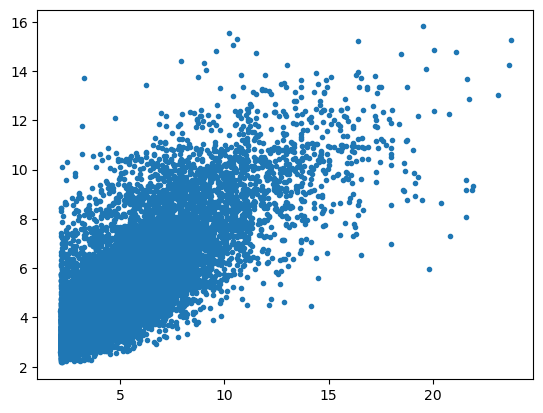

In [9]:
plt.plot(data.target.iloc[start:start+length].to_numpy(), predict.ravel(), ".");

In [41]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [42]:
import joblib
xgb_model = joblib.load('./Models/XGBoost_model.joblib')

In [46]:
xgb_predict = xgb_model.predict(data)
xgb_predict

array([3.6456726, 3.210249 , 4.191978 , ..., 3.284788 , 3.1833699,
       5.830158 ], dtype=float32)

In [45]:
print('Test: R2=', r2_score(data.target, xgb_predict).round(3))

Test: R2= 0.297


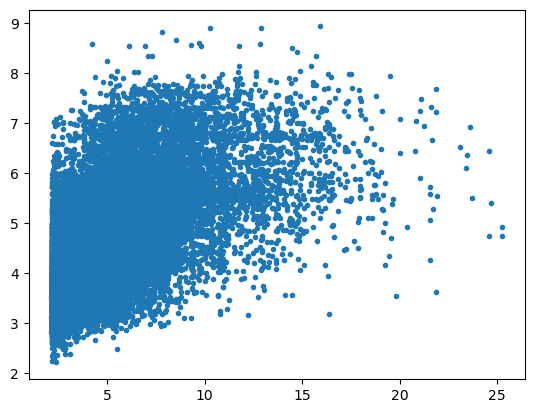

In [47]:
plt.plot(data.target, xgb_predict, ".");

In [40]:
data.head()

,nace,esize_class,gender,age_class,lpk,education,experience,target
0,C,1_49,M,40-49,721,G2,13,8.20
1,C,1_49,F,40-49,334,G2,0,2.51
2,M,50_249,F,40-49,522,G2,18,2.19
3,M,50_249,F,40-49,522,G2,12,2.19
4,M,50_249,F,14-29,522,G2,0,2.19
